# Soap films and minimal surfaces

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def surface_area(v, triangles):
    def triangle_area(triangle):
        i, j, k = triangle
        return 0.5 * jnp.linalg.norm(jnp.cross(v[j]-v[i], v[k]-v[i]))
    return jnp.sum(jax.vmap(triangle_area)(triangles))

In [3]:
def minimize(loss, x, c, step_size, num_steps, cb=lambda i, x: None, cb_every=1000):
    """Constrained minimization by projected gradient descent."""
    @jax.jit
    def step(x):
        g = jax.grad(loss)(x)
        constrained_g = g.at[c].set(0.)
        return x - step_size * constrained_g
    for i in range(num_steps):
        x = step(x)
        if i % cb_every == 0: cb(i, x)
    return x

In [4]:
na, nb = 100, 20
a = jnp.linspace(0, 2*jnp.pi, num=na, endpoint=False)
b = jnp.linspace(0, 4, num=nb)
a, b = jnp.meshgrid(a, b)
a, b = a.flatten(), b.flatten()

In [5]:
## constrain top and bottom row only
c = jnp.where((b == b.min()) | (b == b.max()))[0]

## constrain vertices close to top and bottom
# c = jnp.where((jnp.abs(b - b.min()) < 0.05) | (jnp.abs(b - b.max()) < 0.05))[0]

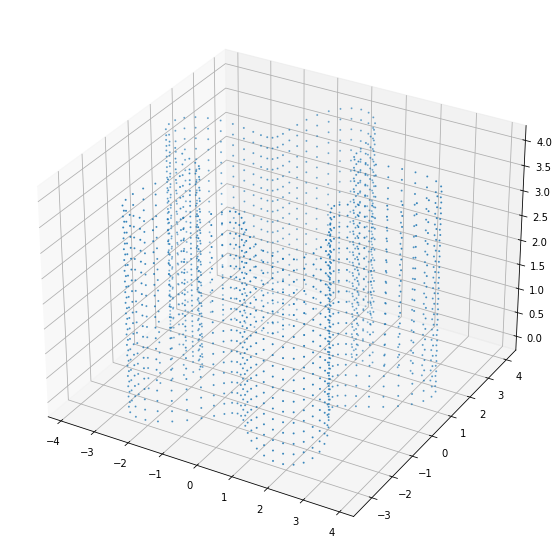

In [6]:
## cylinder
# x = jnp.cos(a)
# y = jnp.sin(a)
# z = b

# star
s = 3 + jnp.sin(5*a)
x = s * jnp.cos(a)
y = s * jnp.sin(a)
z = b

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter3D(x, y, z, s=1)

In [7]:
def make_cylinder_triangulation(ni, nj):
    """Generate a 2D triangulation with left-right gluing."""
    def tri(i, j):
        return jnp.array([[i*nj+j,  i*nj+(j+1)%nj, (i+1)*nj+(j+1)%nj], 
                          [i*nj+j,     (i+1)*nj+j, (i+1)*nj+(j+1)%nj]])
    triangles = jax.vmap(jax.vmap(tri, (None, 0)), (0, None))(jnp.arange(ni-1), jnp.arange(nj))
    return triangles.reshape(-1, 3)

v = jnp.vstack((x, y, z)).T
triangles = make_cylinder_triangulation(nb, na)
v.shape, triangles.shape, c.shape

((2000, 3), (3800, 3), (200,))

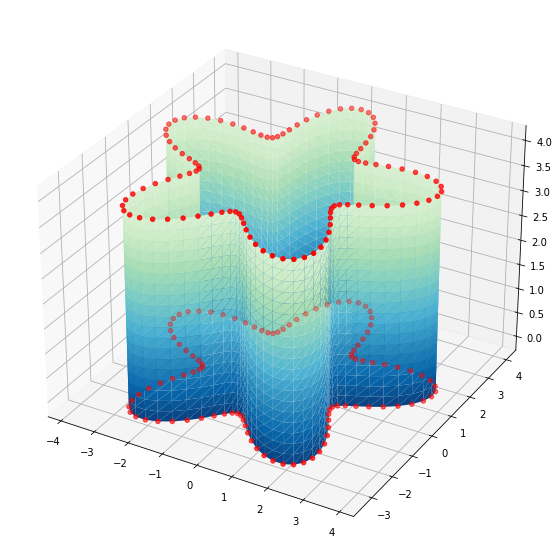

In [8]:
def plot_mesh(v, triangles, c=None):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    kwargs = dict(cmap=plt.cm.GnBu_r, vmin=v[:,2].min(), vmax=v[:,2].max()*1.2)
    ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles=triangles, **kwargs)
    ax.scatter3D(v[c,0], v[c,1], v[c,2], c="red")

plot_mesh(v, triangles, c)

## Minimize the surface area

In [9]:
loss = lambda v: surface_area(v, triangles)
cb = lambda i, x: print(f"i={i} loss={loss(x)}")
v2 = minimize(loss, v, c, step_size=1e-1, num_steps=10000, cb=cb, cb_every=2000)

i=0 loss=113.39701843261719
i=2000 loss=74.79481506347656
i=4000 loss=76.22454833984375
i=6000 loss=76.36495971679688
i=8000 loss=76.3675537109375


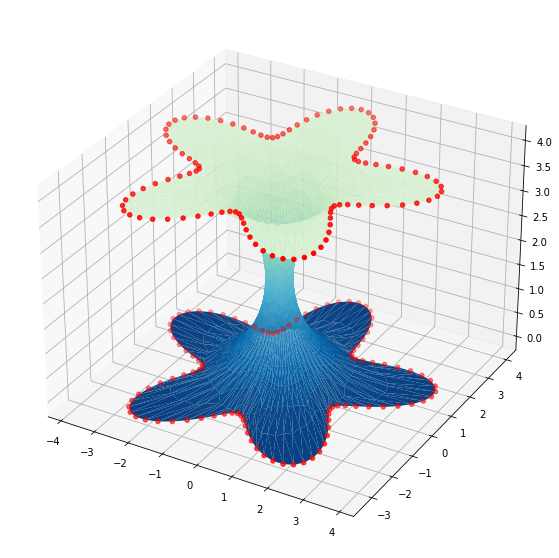

In [10]:
plot_mesh(v2, triangles, c)

## GIF

In [11]:
from IPython.display import clear_output
import gif

frames = []

@gif.frame
def plot(i, v):
    clear_output(True)
    plot_mesh(v, triangles, c)
    plt.title(f"t={i}")
    
def callback(i, x):
    print(f"t={i}")
    frame = plot(i, x)
    frames.append(frame)

num_steps = 10000
v2 = minimize(loss, v, c, step_size=1e-1, num_steps=num_steps, cb=callback, cb_every=100)
callback(num_steps, v2) # one final callback on the result

t=10000


In [12]:
frames_periodic = frames + frames[::-1]
gif.save(frames_periodic, 'min_surface.gif', duration=1, unit="s", between="startend")